In [ ]:
import tensorflow as tf

In [ ]:
from typing import Optional, Any
import warnings
from tifffile import TiffFile, TiffWriter
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import tensorflow as tf
tf.random.set_seed(3)
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from sklearn.metrics import accuracy_score, confusion_matrix, jaccard_score
import itertools
import cv2

In [ ]:
def read_stiff(filename: str, silent=False, rgb_only=False):
    """

    :param filename:    filename of the spectral tiff to read.
    :return:            Tuple[spim, wavelengths, rgb, metadata], where
                        spim: spectral image cube of form [height, width, bands],
                        wavelengths: the center wavelengths of the bands,
                        rgb: a color render of the spectral image [height, width, channels] or None
                        metadata: a free-form metadata string stored in the image, or an empty string
    """
    TIFFTAG_WAVELENGTHS = 65000
    TIFFTAG_METADATA = 65111
    spim = None
    wavelengths = None
    rgb = None
    metadata = None

    first_band_page = 0
    with TiffFile(filename) as tiff:
        # The RGB image is optional, the first band image maybe on the first page:
        first_band_page = 0
        if tiff.pages[first_band_page].ndim == 3:
            rgb = tiff.pages[0].asarray()
            # Ok, the first band image is on the second page
            first_band_page = first_band_page + 1

        multiple_wavelength_lists = False
        multiple_metadata_fields = False
        for band_page in range(first_band_page, len(tiff.pages)):
            # The wavelength list is supposed to be on the first band image.
            # The older write_tiff writes it on all pages, though, so make
            # a note of it.
            tag = tiff.pages[band_page].tags.get(TIFFTAG_WAVELENGTHS)
            tag_value = tag.value if tag else tuple()
            if tag_value:
                if wavelengths is None:
                    wavelengths = tag_value
                elif wavelengths == tag_value:
                    multiple_wavelength_lists = True
                elif wavelengths != tag_value:
                    # Well, the image is just broken then?
                    raise RuntimeError(f'Spectral-Tiff "{filename}" contains multiple differing wavelength lists!')

            # The metadata string, like the wavelength list, is supposed to be
            # on the first band image. The older write_tiff wrote it on all
            # pages, too. Make a note of it.
            tag = tiff.pages[band_page].tags.get(TIFFTAG_METADATA)
            tag_value = tag.value if tag else ''
            if tag_value:
                if metadata is None:
                    metadata = tag_value
                elif metadata == tag_value:
                    multiple_metadata_fields = True
                elif metadata != tag_value:
                    # Well, for some reason there are multiple metadata fields
                    # with varying content. This version of the function does
                    # not care for such fancyness.
                    raise RuntimeError(f'Spectral-Tiff "{filename}" contains multiple differing metadata fields!')

        # The metadata is stored in an ASCII string. It may contain back-slashed
        # hex sequences (unicode codepoints presented as ASCII text). Convert
        # ASCII string back to bytes and decode as unicode sequence.
        if metadata:
            metadata = metadata.encode('ascii').decode('unicode-escape')
        else:
            metadata = ''

        # Some of the early images may have errorneus metadata string.
        # Attempt to fix it:
        if len(metadata) >= 2 and metadata[0] == "'" and metadata[-1] == "'":
            while metadata[0] == "'":
                metadata = metadata[1:]
            while metadata[-1] == "'":
                metadata = metadata[:-1]
            if '\\n' in metadata:
                metadata = metadata.replace('\\n', '\n')

        # Generate a fake wavelength list, if the spectral tiff has managed to
        # lose its own wavelength list.
        if not wavelengths:
            wavelengths = range(0, len(tiff.pages) - 1 if rgb is not None else len(tiff.pages))

        if multiple_wavelength_lists and not silent:
            warnings.warn(f'Spectral-Tiff "{filename}" contains duplicated wavelength lists!')
        if multiple_metadata_fields and not silent:
            warnings.warn(f'Spectral-Tiff "{filename}" contains duplicated metadata fields!')

        if not rgb_only:
            spim = tiff.asarray(key=range(first_band_page, len(tiff.pages)))
            spim = np.transpose(spim, (1, 2, 0))
        else:
            spim = None

        # Make sure the wavelengths are in an ascending order:
        if wavelengths[0] > wavelengths[-1]:
            spim = spim[:, :, ::-1] if spim is not None else None
            wavelengths = wavelengths[::-1]

    # Convert uint16 cube back to float32 cube
    if spim is not None and spim.dtype == 'uint16':
        spim = spim.astype('float32') / (2**16 - 1)

    return spim, np.array(wavelengths), rgb, metadata

In [ ]:
def read_mtiff(filename):
    """
    Read a mask bitmap tiff.

    Mask bitmap tiff contains multiple pages of bitmap masks. The mask label
    is stored in tag 65001 in each page. The mask label is stored as an ASCII
    string that may contain unicode codepoints encoded as ASCII character
    sequences (see unicode-escape encoding in Python docs).

    :param filename:    filename of the mask tiff to read.
    :return:            Dict[label: str, mask: ndarray], where
                        label: the mask label
                        mask: the boolean bitmap associated with the label.
    """
    TIFFTAG_MASK_LABEL = 65001
    masks = dict()
    with TiffFile(filename) as tiff:
        for p in range(0, len(tiff.pages)):
            label_tag = tiff.pages[p].tags.get(TIFFTAG_MASK_LABEL)
            if label_tag is None:
                if p > 0:
                    print(f'** page {p}: no TIFF_MASK_LABEL tag. Ignored.')
                continue
            label = label_tag.value.encode('ascii').decode('unicode-escape')
            mask = tiff.asarray(key=p)
            masks[label] = mask > 0
    return masks

In [ ]:
LABELS = {
            'Specular reflection' : 0,
            'Artery, ICG':          1,
            'Vein':                 2,
            'Stroma, ICG':          3,
            'Blue dye':             4,
            'Red dye':              5,
            'ICG':                  6,
            'Stroma':               7,
            'Umbilical cord':       8,
            'Suture':               9,
            'Artery':               10,
         }

In [ ]:
def get_label_code(label_name):
        return LABELS[label_name]

In [ ]:
REFLECTANCE_IMAGE_PATH = '/content/Reflectance spectral images/'
MASK_IMAGE_PATH = '/content/Set 1 Mask images'

In [ ]:
def create_dataset(image_path,mask_path,classes):
    X = []
    y=[]
    IMAGE_SIZE =128
    image_filenames = listdir(image_path)

    for filename in image_filenames:
        spectra_image, wavelength, rgb, metadata = read_stiff(f"{image_path}/{filename}")  
        image_name = filename.split(".tif")[0]
        mask_image_name = f"{image_name}_masks.tif"
        image_masks_dict = read_mtiff(f"{mask_path}/{mask_image_name}")
        masks  = np.zeros((spectra_image.shape[:2]))
        for label in image_masks_dict:
            spectra_image_mask = image_masks_dict[label].astype(int)
            label_code = get_label_code(label)
            spectra_image_mask[spectra_image_mask == 1] = label_code + 1
            masks = np.maximum(masks,spectra_image_mask)
        y.append(resize(masks,(IMAGE_SIZE,IMAGE_SIZE)))
        X.append(resize(spectra_image,(IMAGE_SIZE,IMAGE_SIZE)))
    
    return X, y

In [ ]:
X, y = create_dataset(REFLECTANCE_IMAGE_PATH,MASK_IMAGE_PATH,LABELS)

In [ ]:
y = np.array(y).astype(int)
X = np.array(X)
#plt.hist(y.flatten())

In [ ]:
# from sklearn.decomposition import PCA
# def pca(x):
#     imgs = []
#     for x_i in x:
#         x_i = x_i.reshape(x_i.shape[0]*x_i.shape[1], -1)
#         pca = PCA(n_components=3)
#         principalComponents = pca.fit_transform(x_i)
#         img = principalComponents.reshape(IMAGE_SIZE,IMAGE_SIZE,3)
#         imgs.append(img)
#     return np.array(imgs)

In [ ]:
# X = pca(X)

In [ ]:
class_colors = np.array([
            [255,0,0],
            [128,128,128],
            [0,128,0],
            [131,255,51],
            [128,0,128],
            [0,0,255],
            [255,255,0],
            [0,100,100],
            [165,42,42],
            [255,0,255],
            [255,165,0],[0,0,0]])
#reshaped_classes = np.array(classes).reshape(-1,1) 

In [ ]:
labelEncoder = LabelEncoder()
n, h, w = y.shape
y_reshaped = y.reshape(-1)
y_reshaped_encoded = labelEncoder.fit_transform(y_reshaped)
y_encoded = y_reshaped_encoded.reshape(n,h,w)

In [ ]:
y_expanded = np.expand_dims(y,axis=3)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,shuffle= True, random_state=42)
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test,len(LABELS)+1)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_reshaped), y= y_reshaped)

#class_weights = class_weight.compute_class_weight("balanced",np.unique(y_reshaped),y_reshaped)
class_weights = {l:c for l,c in zip(np.unique(y_reshaped), class_weights)}
sample_weights = class_weight.compute_sample_weight(class_weights,y_train.reshape(-1,1))
y_n, y_h, y_w = y_train.shape
sample_weights = sample_weights.reshape(y_n,y_h,y_w)

In [ ]:
IMAGE_SIZE =128
IMAGE_CHANNELS = 38
def convo_block(input_shape, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input_shape)
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input_shape, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input_shape)
    x = Dropout(0.1)(x)
    x = Concatenate()([x, skip_features])
    x = convo_block(x, num_filters)
    return x

def build_vgg16_unet(n_classes):
    """ Input """
    input_shape = (IMAGE_SIZE,IMAGE_SIZE,IMAGE_CHANNELS)
    inputs = Input(input_shape)

    """ Pre-trained ResNet50 Model """
    vgg16 = VGG16(include_top=False, weights=None ,input_tensor=inputs) #, input_tensor=inputs
    
    #resnet50.summary()
#     print(resnet50.get_layer(0).output) 

    """ Encoder """
    #s1 = resnet50.layers[0].output                      ##get output from input layer  128 x 128
    #s2 = resnet50.get_layer("conv1_relu").output        ## 64x64
    #s3 = resnet50.get_layer("conv2_block3_out").output  ## 32x32
    #s4 = resnet50.get_layer("conv3_block4_out").output  ## 16x16

    s1 = vgg16.get_layer("block1_conv2").output        ##get output from input layer  128 x 128
    s2 = vgg16.get_layer("block2_conv2").output        ## 64x64
    s3 = vgg16.get_layer("block3_conv3").output  ## 32x32
    s4 = vgg16.get_layer("block4_conv3").output  ## 16x16
    
#     print(s1,s2,s3,s4)
    """ Bridge """
    b1 = vgg16.get_layer("block5_conv3").output  ## 8x8

    """ Decoder """
    d1 = decoder_block(b1, s4, 128)                     ## 16x16
    d2 = decoder_block(d1, s3, 64)                     ## 32x32
    d3 = decoder_block(d2, s2, 32)                     ## 64x64
    d4 = decoder_block(d3, s1, 16)                     ##128x128
 

#     """ Output """
    outputs = Conv2D(n_classes, 1, padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs, name="VGG16_U-Net")
    return model

In [ ]:
n_classes = len(LABELS)+1
model = build_vgg16_unet(n_classes)
model.compile(optimizer="adam", loss="categorical_crossentropy" ,metrics="accuracy",sample_weight_mode="temporal")
model.summary()

Model: "ResNet50_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                8)]                                                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  21952       ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 128, 64  36928       ['block1_conv1[0][0]']           
                                )                                                    

In [ ]:
batch_size = 16
epochs = 1500

In [ ]:
history = model.fit(X_train,y_train_cat,batch_size=batch_size,epochs=epochs)
model.save('/content/drive/MyDrive/IDPModel/vgg16_model_b_32_ep_1500.h5')

Epoch 1/1500
2/2 [==============================] - 6s 3s/step - loss: 2.7063 - accuracy: 0.0666
Epoch 2/1500
2/2 [==============================] - 0s 123ms/step - loss: 2.5312 - accuracy: 0.0894
Epoch 3/1500
2/2 [==============================] - 0s 121ms/step - loss: 2.4581 - accuracy: 0.1169
Epoch 4/1500
2/2 [==============================] - 0s 118ms/step - loss: 2.4021 - accuracy: 0.1399
Epoch 5/1500
2/2 [==============================] - 0s 119ms/step - loss: 2.3672 - accuracy: 0.1543
Epoch 6/1500
2/2 [==============================] - 0s 119ms/step - loss: 2.3318 - accuracy: 0.1724
Epoch 7/1500
2/2 [==============================] - 0s 123ms/step - loss: 2.2947 - accuracy: 0.1872
Epoch 8/1500
2/2 [==============================] - 0s 122ms/step - loss: 2.2564 - accuracy: 0.2079
Epoch 9/1500
2/2 [==============================] - 0s 122ms/step - loss: 2.2195 - accuracy: 0.2308
Epoch 10/1500
2/2 [==============================] - 0s 121ms/step - loss: 2.1937 - accuracy: 0.2459
Ep

In [ ]:
# model.save_weights('ResUnet_weights.h5')

In [ ]:
def get_predicted_mask(filename,class_colors):
    spim, wavelength, rgb_img, metadata = read_stiff(f"{REFLECTANCE_IMAGE_PATH}/{filename}")
    test_image = resize(spim,(IMAGE_SIZE,IMAGE_SIZE)) # spim for spectral image
    test_image = np.expand_dims(test_image, axis=0)
   

# get mask
    image_name = filename.split(".tif")[0]
    filemask = f"{image_name}_masks.tif"
    image_masks_dict = read_mtiff(f"{MASK_IMAGE_PATH}/{filemask}")
    masks = np.zeros((spim.shape[:2]))
    for label in image_masks_dict:
        spectra_image_mask = image_masks_dict[label].astype(int)
        label_code = get_label_code(label)
        spectra_image_mask[spectra_image_mask == 1] = label_code + 1
        masks = np.maximum(masks,spectra_image_mask)
    masks = resize(masks,(IMAGE_SIZE,IMAGE_SIZE))

    gt_mask = masks 
    gt_mask = np.expand_dims(masks, axis=-1)
    combined_gtmask = np.zeros((test_image.shape[1:3]))
    combined_gtmask = np.stack((combined_gtmask,)*3, axis=-1)


    pred_mask = model.predict(test_image)

    pred_mask = np.expand_dims(np.squeeze(np.argmax(pred_mask, axis=3)),axis=-1)
    combined_predmask = np.zeros((test_image.shape[1:3]))
    combined_predmask = np.stack((combined_predmask,)*3, axis=-1)
    
    xy_list_gt = np.where(gt_mask!=0)
    x_list_gt = xy_list_gt[0]
    y_list_gt = xy_list_gt[1]

    for x, y in zip(x_list_gt, y_list_gt):
        idx = gt_mask[x,y,0].astype(int)
        combined_gtmask[x,y,:] = class_colors[idx]
        
    xy_list_pred_mask = np.where(pred_mask!=0)
    x_list_pred_mask = xy_list_pred_mask[0]
    y_list_pred_mask = xy_list_pred_mask[1]

    for x, y in zip(x_list_pred_mask, y_list_pred_mask):
        idxpred = pred_mask[x,y,0]
        combined_predmask[x,y,:] = class_colors[idxpred]
    
    return rgb_img, combined_gtmask, combined_predmask

In [ ]:
class_colors = np.array([
            [255,0,0],
            [128,128,128],
            [0,128,0],
            [131,255,51],
            [128,0,128],
            [0,0,255],
            [255,255,0],
            [0,100,100],
            [165,42,42],
            [255,0,255],
            [255,165,0],[0,0,0]])

In [ ]:
filename = "upper_6_icg.tif"

1/1 [==============================] - 0s 24ms/step


Text(0.5, 1.0, 'Predicted truth mask')

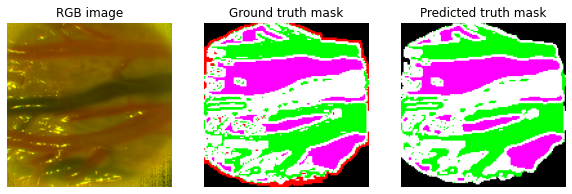

In [ ]:
rgb_image, gt_mask,pred_mask = get_predicted_mask(filename,class_colors)
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 3, 1)
plt.imshow(rgb_image)
plt.axis('off')
plt.title("RGB image") 


# Adds a subplot at the 2nd position
fig.add_subplot(1, 3, 2)  
# showing image
plt.imshow(gt_mask)
plt.axis('off')
plt.title("Ground truth mask")
# Adds a subplot at the 3rd position
fig.add_subplot(1, 3, 3)
  
# showing image
plt.imshow(pred_mask)
plt.axis('off')
plt.title("Predicted truth mask")

# Creating non mask images mask

In [ ]:
def get_predicted_mask(filename,class_colors):
    spim, wavelength, rgb_img, metadata = read_stiff(f"{REFLECTANCE_IMAGE_PATH}/{filename}")
    test_image = resize(spim,(IMAGE_SIZE,IMAGE_SIZE)) # spim for spectral image
    test_image = np.expand_dims(test_image, axis=0)
   


    pred_mask = model.predict(test_image)

    pred_mask = np.expand_dims(np.squeeze(np.argmax(pred_mask, axis=3)),axis=-1)
    combined_predmask = np.zeros((test_image.shape[1:3]))
    combined_predmask = np.stack((combined_predmask,)*3, axis=-1)

        
    xy_list_pred_mask = np.where(pred_mask!=0)
    x_list_pred_mask = xy_list_pred_mask[0]
    y_list_pred_mask = xy_list_pred_mask[1]

    for x, y in zip(x_list_pred_mask, y_list_pred_mask):
        idxpred = pred_mask[x,y,0]
        combined_predmask[x,y,:] = class_colors[idxpred]
    
    return rgb_img, combined_predmask

In [ ]:
rgb_image,pred_mask = get_predicted_mask(filename,class_colors)
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)
plt.imshow(rgb_image)
plt.axis('off')
plt.title("RGB image") 

fig.add_subplot(1, 2, 2)
  
# showing image
plt.imshow(pred_mask)
plt.axis('off')
plt.title("Predicted truth mask")

# Classwise mask Generation


In [ ]:
def get_predicted_mask(filename,class_colors):
    spim, wavelength, rgb_img, metadata = read_stiff(f"{REFLECTANCE_IMAGE_PATH}/{filename}")
    test_image = resize(spim,(IMAGE_SIZE,IMAGE_SIZE)) # spim for spectral image
    test_image = np.expand_dims(test_image, axis=0)
   

# get mask
    image_name = filename.split(".tif")[0]
    filemask = f"{image_name}, mask.tif"
    image_masks_dict = read_mtiff(f"{MASK_IMAGE_PATH}/{filemask}")
    masks = np.zeros((spim.shape[:2]))
    for label in image_masks_dict:
        spectra_image_mask = image_masks_dict[label].astype(int)
        label_code = get_label_code(label)
        spectra_image_mask[spectra_image_mask == 1] = label_code + 1
        masks = np.maximum(masks,spectra_image_mask)
    masks = resize(masks,(IMAGE_SIZE,IMAGE_SIZE))

    gt_mask = masks 
    gt_mask = np.expand_dims(masks, axis=-1)
    combined_gtmask = np.zeros((test_image.shape[1:3]))
    combined_gtmask = np.stack((combined_gtmask,)*3, axis=-1)


    pred_mask = model.predict(test_image)
    
    return rgb_img, combined_gtmask, pred_mask

In [ ]:
IMAGE_SIZE=128

In [ ]:
rgb_image, gt_mask,pred_mask = get_predicted_mask(filename,class_colors)

In [ ]:
plt.imshow(pred_mask.squeeze()[:, :, 3])

In [ ]:
nn=7
normalized = pred_mask.squeeze()[:, :, nn] / np.max((pred_mask.squeeze()[:, :, nn]))
print(np.mean(normalized))
out = np.zeros((128, 128))
out[normalized > np.mean(normalized)] = 255
out[normalized < np.mean(normalized)] = 0
out = out.astype(np.uint8)
plt.imshow(out)
plt.axis('off')
#plt.show()
save_results_to = 'G:/Download after 26102022/IndustrialProject/data/testimg/createdMask/'
#plt.savefig(save_results_to + 'image.png')

fig1 = plt.gcf()
plt.show()
plt.draw()
#fig1.savefig(save_results_to +'tessstttyyy.png')

# Genarate all mask using all the available images in folder

In [ ]:
import os
# assign directory
directory = 'G:/Download after 26102022/IndustrialProject/data/aflat-fielded/'
 
# iterate over files in
# that directory
for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        for x in range(12):
            nn=x
            normalized = pred_mask.squeeze()[:, :, nn] / np.max((pred_mask.squeeze()[:, :, nn]))

            #maskname= yy;
            if x == 0:
                yy= 'Background';
                continue;
            elif x == 1:
                yy= 'specularity';
            elif  x==2:
                yy= 'arteryICG';
            elif x==3:
                yy= 'vein';
            elif  x==4:
                yy= 'stromaICG';
            elif x==5:
                yy= 'BlueDye';
                continue;
            elif x==6:
                yy= 'RedDye';
                continue;
            elif x==7:
                yy= 'ICG';
                continue;
            elif x==8:
                yy= 'stroma';
            elif x==9:
                yy= 'umbilical cord';
            elif x==10:
                yy= 'suture';
            elif x==11:
                yy= 'artery';
            newfilename = filename.split(".tif")[0]
            maskname= f"{newfilename}-DL_{yy}"

            #print(np.mean(normalized))
            #maskNum = f"Mask {yy}"
            print(maskname)
            out = np.zeros((128, 128))
            out[normalized > np.mean(normalized)] = 255
            out[normalized < np.mean(normalized)] = 0
            out = out.astype(np.uint8)
            plt.imshow(out)
            plt.axis('off')
            fig1 = plt.gcf()
            plt.show()
            plt.draw()
            dir= 'G:/Download after 26102022/IndustrialProject/data/all mask2/'
            #image_masks_dict = read_mtiff(f"{MASK_IMAGE_PATH}/{filemask}")
            #filemask = f"{image_name}, mask.tif"
            #plt.savefig(save_results_to + 'image.png', dpi = 300)
            #plt.savefig('foo.png')
            fig1.savefig(dir+f"{maskname}.png")